<a href="https://colab.research.google.com/github/aiscience-22/UA_War/blob/machine_learning_0.03/Twitter_analysis_by_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()


Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Reading package lists... Done


In [2]:
# Download a Postgres driver that will allow Spark to interact with Postgres
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2022-08-31 04:04:52--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar.4’

postgresql-42.2.16. 100%[===================>] 979.38K  1.59MB/s    in 0.6s    

2022-08-31 04:04:54 (1.59 MB/s) - ‘postgresql-42.2.16.jar.4’ saved [1002883/1002883]



In [3]:
# Add drivers to Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://uaresources.s3.us-west-1.amazonaws.com/twitter_sentiments.csv"

spark.sparkContext.addFile(url)
text_df = spark.read.csv(SparkFiles.get("twitter_sentiments.csv"), sep=",", header=True, inferSchema=True)


# Show DataFrame
text_df.show()

+---------+---------+-----------+--------------------+-------------------+------------+--------------------+--------+--------------+----------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|following|followers|totaltweets|       usercreatedts|     tweetcreatedts|retweetcount|            hashtags|language|favorite_count|is_retweet|is_quote_status|         extractedts|        cleaned_text|            negative|             neutral|            positive|
+---------+---------+-----------+--------------------+-------------------+------------+--------------------+--------+--------------+----------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|       51|     3362|      71331|2011-09-08 02:34:...|2022-08-01 00:00:00|           0|[{'text': 'Russia...|      en|           0.0|     false|          false|2022-08-01 02:30:...|the conflict is b...|  0.

In [5]:
# Convert DataFrame to Pandas
tweets_df = text_df.toPandas()
print(tweets_df.shape)
tweets_df.head(5)

(390649, 16)


,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,is_retweet,is_quote_status,extractedts,cleaned_text,negative,neutral,positive
0,51,3362,71331,2011-09-08 02:34:54.000000,2022-08-01 00:00:00,0,"[{'text': 'RussiaUkraine', 'indices': [4, 18]}...",en,0.0,False,False,2022-08-01 02:30:13.601013,the conflict is being cast in binaries making ...,0.602712,0.381634,0.015654
1,137,114789,315096,2010-08-20 11:19:22.000000,2022-08-01 00:00:01,0,"[{'text': 'UkraineCrisis', 'indices': [133, 14...",en,1.0,False,False,2022-08-01 01:44:58.884242,the world is in dire straits as it is not equi...,0.876023,0.116907,0.007070
2,7284,6963,264990,2009-06-07 05:36:09.000000,2022-08-01 00:00:01,0,"[{'text': 'UkraineInvasion', 'indices': [100, ...",en,1.0,False,False,2022-08-01 02:36:44.414025,owner of ukraines largest grain exporter kille...,0.833382,0.162987,0.003631
3,1080,14429,35346,2013-05-11 18:28:57.000000,2022-08-01 00:00:02,1,"[{'text': 'Iran', 'indices': [4, 9]}, {'text':...",en,2.0,False,False,2022-08-01 05:13:47.917189,why relations likely wont go beyond cooperati...,0.409764,0.567718,0.022518
4,1980,1827,67996,2007-03-23 21:01:28.000000,2022-08-01 00:00:02,1,"[{'text': 'ToryFascistDictatorship', 'indices'...",en,0.0,True,True,2022-08-01 02:36:44.402793,its happening on live tv,0.061496,0.848844,0.089660


In [6]:
# Drop null values
tweets_df=tweets_df.dropna()
print(tweets_df.shape)

(390642, 16)


In [7]:
# Check data types
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390642 entries, 0 to 390648
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   following        390642 non-null  int32  
 1   followers        390642 non-null  int32  
 2   totaltweets      390642 non-null  int32  
 3   usercreatedts    390642 non-null  object 
 4   tweetcreatedts   390642 non-null  object 
 5   retweetcount     390642 non-null  int32  
 6   hashtags         390642 non-null  object 
 7   language         390642 non-null  object 
 8   favorite_count   390642 non-null  float64
 9   is_retweet       390642 non-null  bool   
 10  is_quote_status  390642 non-null  bool   
 11  extractedts      390642 non-null  object 
 12  cleaned_text     390642 non-null  object 
 13  negative         390642 non-null  float64
 14  neutral          390642 non-null  float64
 15  positive         390642 non-null  float64
dtypes: bool(2), float64(4), int32(4), obje

In [8]:
# Change the dtypes of usercreatedts, tweetcreatedts, and extractedts to datetime64 for easier operation later
tweets_df["usercreatedts"] = pd.to_datetime(tweets_df["usercreatedts"])
tweets_df["tweetcreatedts"] = pd.to_datetime(tweets_df["tweetcreatedts"])
tweets_df["extractedts"] = pd.to_datetime(tweets_df["extractedts"])

# check dtypes
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390642 entries, 0 to 390648
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   following        390642 non-null  int32         
 1   followers        390642 non-null  int32         
 2   totaltweets      390642 non-null  int32         
 3   usercreatedts    390642 non-null  datetime64[ns]
 4   tweetcreatedts   390642 non-null  datetime64[ns]
 5   retweetcount     390642 non-null  int32         
 6   hashtags         390642 non-null  object        
 7   language         390642 non-null  object        
 8   favorite_count   390642 non-null  float64       
 9   is_retweet       390642 non-null  bool          
 10  is_quote_status  390642 non-null  bool          
 11  extractedts      390642 non-null  datetime64[ns]
 12  cleaned_text     390642 non-null  object        
 13  negative         390642 non-null  float64       
 14  neutral          390

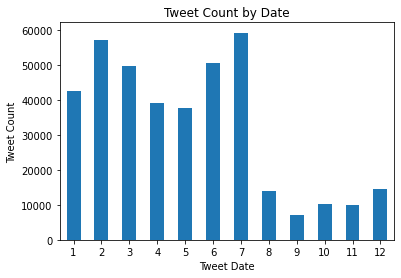

In [9]:
# Visualize tweet counts by date
# get dates in the dataframe 
dates = tweets_df["tweetcreatedts"].dt.day
# group tweet timestamps by date and get tweet count for each date
tweetcount_by_date = tweets_df["tweetcreatedts"].groupby(dates).size()

# plot bar graph of tweet count by date
tweetcount_by_date.plot.bar();

plt.title("Tweet Count by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=0)
plt.show()

In [10]:
# Change the negative score to negative value
tweets_df["negative"] = -1.0*tweets_df["negative"]
tweets_df.head(5)

,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,is_retweet,is_quote_status,extractedts,cleaned_text,negative,neutral,positive
0,51,3362,71331,2011-09-08 02:34:54,2022-08-01 00:00:00,0,"[{'text': 'RussiaUkraine', 'indices': [4, 18]}...",en,0.0,False,False,2022-08-01 02:30:13.601013,the conflict is being cast in binaries making ...,-0.602712,0.381634,0.015654
1,137,114789,315096,2010-08-20 11:19:22,2022-08-01 00:00:01,0,"[{'text': 'UkraineCrisis', 'indices': [133, 14...",en,1.0,False,False,2022-08-01 01:44:58.884242,the world is in dire straits as it is not equi...,-0.876023,0.116907,0.007070
2,7284,6963,264990,2009-06-07 05:36:09,2022-08-01 00:00:01,0,"[{'text': 'UkraineInvasion', 'indices': [100, ...",en,1.0,False,False,2022-08-01 02:36:44.414025,owner of ukraines largest grain exporter kille...,-0.833382,0.162987,0.003631
3,1080,14429,35346,2013-05-11 18:28:57,2022-08-01 00:00:02,1,"[{'text': 'Iran', 'indices': [4, 9]}, {'text':...",en,2.0,False,False,2022-08-01 05:13:47.917189,why relations likely wont go beyond cooperati...,-0.409764,0.567718,0.022518
4,1980,1827,67996,2007-03-23 21:01:28,2022-08-01 00:00:02,1,"[{'text': 'ToryFascistDictatorship', 'indices'...",en,0.0,True,True,2022-08-01 02:36:44.402793,its happening on live tv,-0.061496,0.848844,0.089660


In [11]:
# Extract negative score of twits and time, when they were created
negative_tweets_df = tweets_df[['tweetcreatedts', 'negative']]
negative_tweets_df.head(5)

,tweetcreatedts,negative
0,2022-08-01 00:00:00,-0.602712
1,2022-08-01 00:00:01,-0.876023
2,2022-08-01 00:00:01,-0.833382
3,2022-08-01 00:00:02,-0.409764
4,2022-08-01 00:00:02,-0.061496


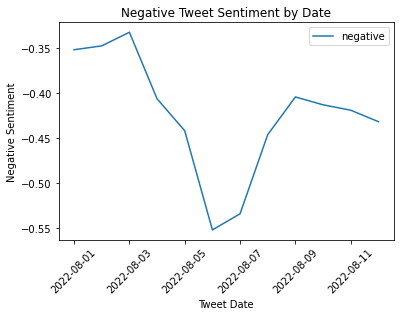

In [12]:
# Visualize negative tweet sentiment by date
# get dates in the dataframe 
dates = negative_tweets_df["tweetcreatedts"].dt.day
# group tweet timestamps by date and get mean negative score for each date
negative_by_date =  negative_tweets_df.groupby([negative_tweets_df['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet negative sentiment by date
negative_by_date.plot.line();

plt.title("Negative Tweet Sentiment by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [13]:
# Extract positive score of twits and time, when they were created
positive_tweets_df = tweets_df[['tweetcreatedts', 'negative']]
positive_tweets_df.head(5)

,tweetcreatedts,negative
0,2022-08-01 00:00:00,-0.602712
1,2022-08-01 00:00:01,-0.876023
2,2022-08-01 00:00:01,-0.833382
3,2022-08-01 00:00:02,-0.409764
4,2022-08-01 00:00:02,-0.061496


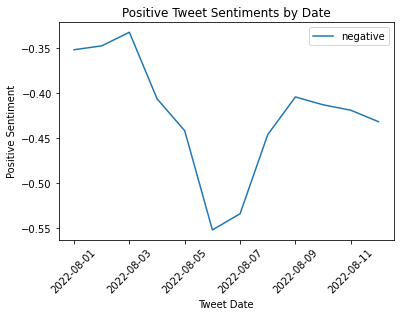

In [14]:
# Visualize positive tweet sentiment by date
# get dates in the dataframe 
dates = positive_tweets_df["tweetcreatedts"].dt.day
# group tweet timestamps by date and get mean positive score for each date
positive_by_date =  positive_tweets_df.groupby([positive_tweets_df['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_by_date.plot.line();

plt.title("Positive Tweet Sentiments by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

# Analysis for Ukraine - Russia comparison


In [15]:
# Analysis for Ukraine word
ukraine_df = tweets_df[tweets_df['cleaned_text'].str.contains('ukraine')]
ukraine_df.head(5)

,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,is_retweet,is_quote_status,extractedts,cleaned_text,negative,neutral,positive
2,7284,6963,264990,2009-06-07 05:36:09,2022-08-01 00:00:01,0,"[{'text': 'UkraineInvasion', 'indices': [100, ...",en,1.0,False,False,2022-08-01 02:36:44.414025,owner of ukraines largest grain exporter kille...,-0.833382,0.162987,0.003631
20,1338,425,102379,2012-11-07 01:49:50,2022-08-01 00:00:53,231,"[{'text': 'StandWithUkraine', 'indices': [164,...",en,0.0,True,False,2022-08-01 02:36:44.095816,on july ukrainians in new york held a protes...,-0.153614,0.550906,0.295480
28,206,205,55044,2007-07-28 20:43:15,2022-08-01 00:01:20,8,"[{'text': 'SlavaUkraini', 'indices': [234, 247]}]",en,0.0,True,False,2022-08-01 02:30:13.023346,russian military authorities are offsetting ca...,-0.791696,0.190806,0.017498
37,4184,1437,31197,2011-07-19 11:07:21,2022-08-01 00:01:47,2,"[{'text': 'UkraineRussiaWar', 'indices': [119,...",en,3.0,False,False,2022-08-01 08:44:38.137051,it remains to be seen if ukraine has enough tr...,-0.237993,0.740983,0.021024
54,5845,6798,280861,2012-09-20 15:20:09,2022-08-01 00:02:54,0,"[{'text': 'Livestream', 'indices': [0, 11]}, {...",en,0.0,False,False,2022-08-01 10:29:39.684690,cctv day the ukraine war multiple views via,-0.095478,0.857893,0.046629


In [16]:
# Extract negative score of twits and time, when they were created
negative_for_ukraine = ukraine_df[['tweetcreatedts', 'negative']]
negative_for_ukraine.rename(columns={"negative": "ukraine_negative"})
negative_for_ukraine.head(5)

,tweetcreatedts,negative
2,2022-08-01 00:00:01,-0.833382
20,2022-08-01 00:00:53,-0.153614
28,2022-08-01 00:01:20,-0.791696
37,2022-08-01 00:01:47,-0.237993
54,2022-08-01 00:02:54,-0.095478


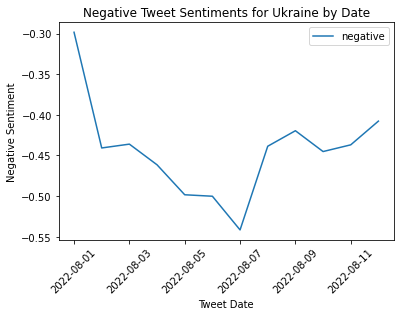

In [17]:
# Visualize tweet negative sentiment for Ukraine by date
# get dates in the dataframe 
dates = negative_for_ukraine["tweetcreatedts"].dt.day
# group tweet timestamps by date and get mean negative score for each date
negative_ukraine_by_date =  negative_for_ukraine.groupby([negative_for_ukraine['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_ukraine_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Ukraine by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [18]:
# Extract positive score of twits and time, when they were created
positive_for_ukraine = ukraine_df[['tweetcreatedts', 'positive']]
positive_for_ukraine.head(5)

,tweetcreatedts,positive
2,2022-08-01 00:00:01,0.003631
20,2022-08-01 00:00:53,0.295480
28,2022-08-01 00:01:20,0.017498
37,2022-08-01 00:01:47,0.021024
54,2022-08-01 00:02:54,0.046629


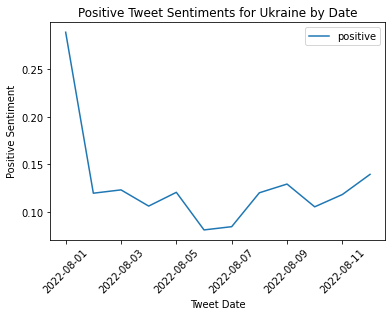

In [19]:
# Visualize tweet positive sentiment for Ukraine by date
# get dates in the dataframe 
dates = positive_for_ukraine["tweetcreatedts"].dt.day
# group tweet timestamps by date and get mean positive score for each date
positive_ukraine_by_date =  positive_for_ukraine.groupby([positive_for_ukraine['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_ukraine_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Ukraine by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

In [20]:
# Analysis for Russia word
russia_df = tweets_df[tweets_df['cleaned_text'].str.contains('russia')]
russia_df.head(5)

,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,is_retweet,is_quote_status,extractedts,cleaned_text,negative,neutral,positive
2,7284,6963,264990,2009-06-07 05:36:09,2022-08-01 00:00:01,0,"[{'text': 'UkraineInvasion', 'indices': [100, ...",en,1.0,False,False,2022-08-01 02:36:44.414025,owner of ukraines largest grain exporter kille...,-0.833382,0.162987,0.003631
6,478,163,6760,2014-12-26 00:31:46,2022-08-01 00:00:08,76,"[{'text': 'Ukraine', 'indices': [81, 89]}, {'t...",en,0.0,True,False,2022-08-01 02:30:13.418591,russian rocket killed of one of the most dedic...,-0.921962,0.073275,0.004763
8,5001,1912,163860,2012-06-23 01:23:23,2022-08-01 00:00:10,454,"[{'text': 'sanctions', 'indices': [42, 52]}, {...",en,0.0,True,False,2022-08-01 00:51:32.929302,are italian companies massively bypassing agai...,-0.264494,0.677277,0.058229
9,478,59,34296,2009-10-19 22:54:51,2022-08-01 00:00:10,43,"[{'text': 'Ukraine', 'indices': [79, 87]}, {'t...",en,0.0,True,False,2022-08-01 01:44:58.780045,turkey refused russia joint production of bayr...,-0.555852,0.435082,0.009066
10,5001,1365,77636,2014-01-03 09:33:28,2022-08-01 00:00:11,29,"[{'text': 'Ukraine', 'indices': [222, 230]}, {...",en,0.0,True,False,2022-08-01 02:36:44.357231,zelensky formal legal recognition of russia as...,-0.151011,0.763817,0.085172


In [21]:
# Extract negative score for Russia of twits and time, when they were created
negative_for_russia = russia_df[['tweetcreatedts', 'negative']]
negative_for_russia.head(5)

,tweetcreatedts,negative
2,2022-08-01 00:00:01,-0.833382
6,2022-08-01 00:00:08,-0.921962
8,2022-08-01 00:00:10,-0.264494
9,2022-08-01 00:00:10,-0.555852
10,2022-08-01 00:00:11,-0.151011


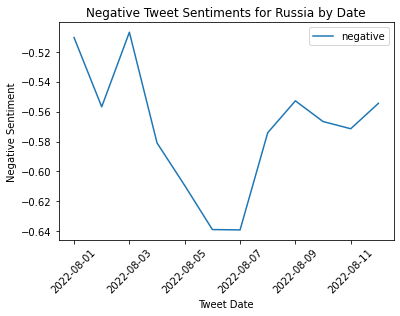

In [22]:
# Visualize negative tweet sentiment for Rossia by date
# get dates in the dataframe 
dates = negative_for_russia["tweetcreatedts"].dt.day
# group tweet timestamps by date and get average negative score for each date
negative_russia_by_date =  negative_for_russia.groupby([negative_for_russia['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_russia_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Russia by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [23]:
# Extract positive score of twits for Russia and time, when they were created
positive_for_russia = russia_df[['tweetcreatedts', 'positive']]
positive_for_russia.head(5)

,tweetcreatedts,positive
2,2022-08-01 00:00:01,0.003631
6,2022-08-01 00:00:08,0.004763
8,2022-08-01 00:00:10,0.058229
9,2022-08-01 00:00:10,0.009066
10,2022-08-01 00:00:11,0.085172


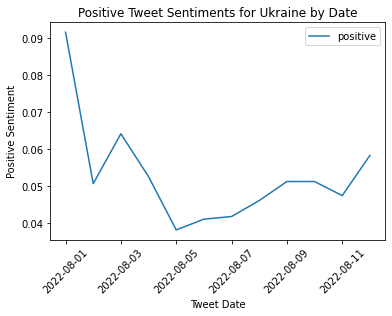

In [24]:
# Visualize tweet positive sentiment for Russia by date
# get dates in the dataframe 
dates = positive_for_russia["tweetcreatedts"].dt.day
# group tweet timestamps by date and get average positive score for each date
positive_russia_by_date =  positive_for_russia.groupby([positive_for_russia['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_russia_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Ukraine by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

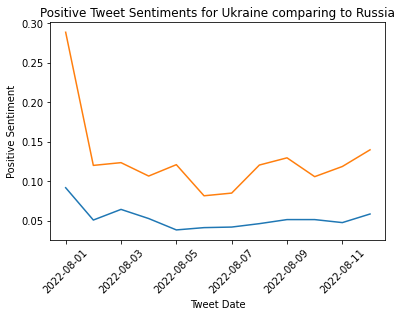

In [25]:
# The plot for Ukraine and Russia positive together
ax = plt.subplot()
plt.title("Positive Tweet Sentiments for Ukraine comparing to Russia")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
ax.plot(positive_russia_by_date['positive'])
ax.plot(positive_ukraine_by_date['positive'])



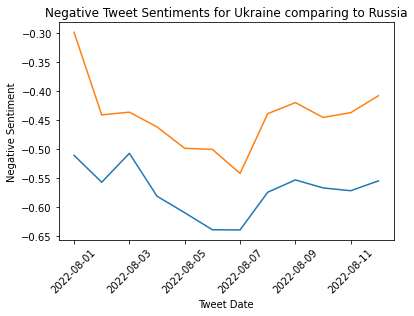

In [26]:
# The plot for Ukraine and Russia negative together
ax = plt.subplot()
plt.title("Negative Tweet Sentiments for Ukraine comparing to Russia")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
ax.plot(negative_russia_by_date['negative'])
ax.plot(negative_ukraine_by_date['negative'])

# Analysis for Zelensky - Putin comparison

In [27]:
# Analysis for Zelensky word
zelensky_df = tweets_df[tweets_df['cleaned_text'].str.contains('ukraine')]
zelensky_df.head(5)

,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,is_retweet,is_quote_status,extractedts,cleaned_text,negative,neutral,positive
2,7284,6963,264990,2009-06-07 05:36:09,2022-08-01 00:00:01,0,"[{'text': 'UkraineInvasion', 'indices': [100, ...",en,1.0,False,False,2022-08-01 02:36:44.414025,owner of ukraines largest grain exporter kille...,-0.833382,0.162987,0.003631
20,1338,425,102379,2012-11-07 01:49:50,2022-08-01 00:00:53,231,"[{'text': 'StandWithUkraine', 'indices': [164,...",en,0.0,True,False,2022-08-01 02:36:44.095816,on july ukrainians in new york held a protes...,-0.153614,0.550906,0.295480
28,206,205,55044,2007-07-28 20:43:15,2022-08-01 00:01:20,8,"[{'text': 'SlavaUkraini', 'indices': [234, 247]}]",en,0.0,True,False,2022-08-01 02:30:13.023346,russian military authorities are offsetting ca...,-0.791696,0.190806,0.017498
37,4184,1437,31197,2011-07-19 11:07:21,2022-08-01 00:01:47,2,"[{'text': 'UkraineRussiaWar', 'indices': [119,...",en,3.0,False,False,2022-08-01 08:44:38.137051,it remains to be seen if ukraine has enough tr...,-0.237993,0.740983,0.021024
54,5845,6798,280861,2012-09-20 15:20:09,2022-08-01 00:02:54,0,"[{'text': 'Livestream', 'indices': [0, 11]}, {...",en,0.0,False,False,2022-08-01 10:29:39.684690,cctv day the ukraine war multiple views via,-0.095478,0.857893,0.046629


In [28]:
# Extract negative score for Zelensky of twits and time, when they were created
negative_for_zelensky = zelensky_df[['tweetcreatedts', 'negative']]
negative_for_zelensky.rename(columns={"negative": "Zelensky_negative"})
negative_for_zelensky.head(5)

,tweetcreatedts,negative
2,2022-08-01 00:00:01,-0.833382
20,2022-08-01 00:00:53,-0.153614
28,2022-08-01 00:01:20,-0.791696
37,2022-08-01 00:01:47,-0.237993
54,2022-08-01 00:02:54,-0.095478


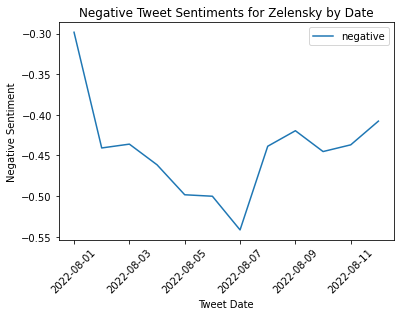

In [29]:
# Visualize negative tweet sentiment for Zelensky by date
# get dates in the dataframe 
dates = negative_for_zelensky["tweetcreatedts"].dt.day
# group tweet timestamps by date and get average negative score for each date
negative_zelensky_by_date =  negative_for_zelensky.groupby([negative_for_zelensky['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_zelensky_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Zelensky by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [30]:
# Extract positive score for Zelensky of twits and time, when they were created
positive_for_zelensky = zelensky_df[['tweetcreatedts', 'positive']]
positive_for_zelensky.head(5)

,tweetcreatedts,positive
2,2022-08-01 00:00:01,0.003631
20,2022-08-01 00:00:53,0.295480
28,2022-08-01 00:01:20,0.017498
37,2022-08-01 00:01:47,0.021024
54,2022-08-01 00:02:54,0.046629


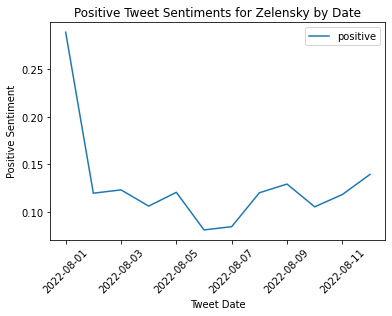

In [31]:
# Visualize positive tweet sentiment for Zelensky by date
# get dates in the dataframe 
dates = positive_for_zelensky["tweetcreatedts"].dt.day
# group tweet timestamps by date and get average negative score for each date
positive_zelensky_by_date =  positive_for_zelensky.groupby([positive_for_zelensky['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_zelensky_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Zelensky by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

In [32]:
# Analysis for Putin word
putin_df = tweets_df[tweets_df['cleaned_text'].str.contains('putin')]
putin_df.head(5)

,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,is_retweet,is_quote_status,extractedts,cleaned_text,negative,neutral,positive
19,59,187,21958,2013-02-12 03:01:57,2022-08-01 00:00:51,1315,"[{'text': 'StandWithUkraine', 'indices': [226,...",en,0.0,True,False,2022-08-01 02:36:44.153265,today prime minister presented president with ...,-0.018900,0.256866,0.724234
27,1624,387,1229,2008-05-14 18:33:40,2022-08-01 00:01:12,1185,"[{'text': 'Kosovo', 'indices': [18, 25]}, {'te...",en,0.0,True,False,2022-08-01 00:29:54.975188,if serbia invades we should defend the kosova...,-0.867248,0.127092,0.005660
51,2701,3040,61275,2011-07-16 18:00:30,2022-08-01 00:02:37,1192,"[{'text': 'Kosovo', 'indices': [18, 25]}, {'te...",en,0.0,True,False,2022-08-01 00:45:07.952755,if serbia invades we should defend the kosova...,-0.867248,0.127092,0.005660
70,2096,1663,95629,2013-04-09 11:49:03,2022-08-01 00:03:47,73,"[{'text': 'Russia', 'indices': [221, 228]}]",en,0.0,True,False,2022-08-01 00:51:31.266348,anatoly chubais former putin adviser who left ...,-0.549840,0.436652,0.013508
71,2228,286,742,2014-05-27 15:33:33,2022-08-01 00:03:49,1192,"[{'text': 'Kosovo', 'indices': [18, 25]}, {'te...",en,0.0,True,False,2022-08-01 00:45:06.706657,if serbia invades we should defend the kosova...,-0.867248,0.127092,0.005660


In [33]:
# Extract negative score for Putin of twits and time, when they were created
negative_for_putin = putin_df[['tweetcreatedts', 'negative']]
negative_for_putin.head(5)

,tweetcreatedts,negative
19,2022-08-01 00:00:51,-0.018900
27,2022-08-01 00:01:12,-0.867248
51,2022-08-01 00:02:37,-0.867248
70,2022-08-01 00:03:47,-0.549840
71,2022-08-01 00:03:49,-0.867248


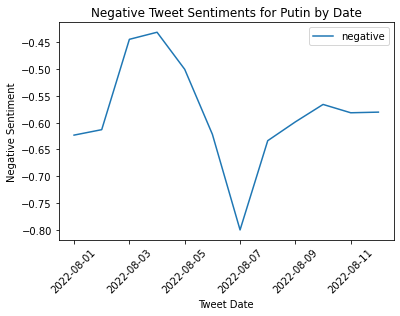

In [34]:
# Visualize negative tweet sentiment for Putin by date
# get dates in the dataframe 
dates = negative_for_putin["tweetcreatedts"].dt.day
# group tweet timestamps by date and get average negative score for each date
negative_putin_by_date =  negative_for_putin.groupby([negative_for_putin['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_putin_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Putin by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [35]:
# Extract positive score for Putin of twits and time, when they were created
positive_for_putin = putin_df[['tweetcreatedts', 'positive']]
positive_for_putin.head(5)

,tweetcreatedts,positive
19,2022-08-01 00:00:51,0.724234
27,2022-08-01 00:01:12,0.005660
51,2022-08-01 00:02:37,0.005660
70,2022-08-01 00:03:47,0.013508
71,2022-08-01 00:03:49,0.005660


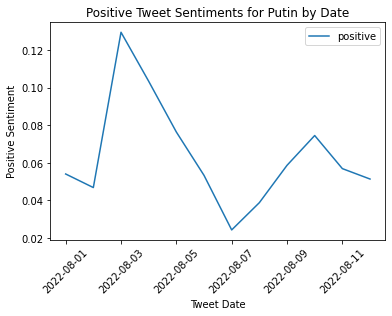

In [36]:
# Visualize positive tweet sentiment for Putin by date
# get dates in the dataframe 
dates = positive_for_putin["tweetcreatedts"].dt.day
# group tweet timestamps by date and get average negative score for each date
positive_putin_by_date =  positive_for_putin.groupby([positive_for_putin['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_putin_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Putin by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

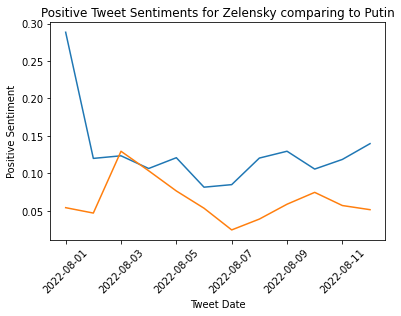

In [37]:
# The plot comparing positive score for Zelensky and Putin
ax = plt.subplot()
plt.title("Positive Tweet Sentiments for Zelensky comparing to Putin")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
ax.plot(positive_zelensky_by_date['positive'])
ax.plot(positive_putin_by_date['positive'])

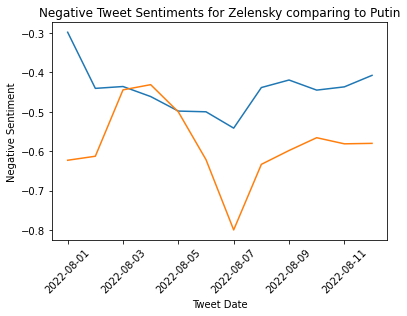

In [38]:
# The plot comparing negative score for Zelensky and Putin
ax = plt.subplot()
plt.title("Negative Tweet Sentiments for Zelensky comparing to Putin")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
ax.plot(negative_zelensky_by_date['negative'])
ax.plot(negative_putin_by_date['negative'])

**Get our transformed raw data into our database**

In [ ]:
# Store environmental variable
from getpass import getpass
password = getpass('password')
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://tweets.cnzbbvrrhst7.us-west-1.rds.amazonaws.com:5432/postgres"
config = {"user":"uatweets",
          "password": password,
          "driver":"org.postgresql.Driver"}

In [ ]:
# Write DataFrame to active_user table in RDS
tweets_df.write.jdbc(url=jdbc_url, table='twitter_sentiments.csv', mode=mode, properties=config)

In [ ]:
# Saving the data
file_path = "/Users/olgapodolska/Desktop/UA_War_my/resources/twitter_sentiments.csv"
tweets_df.to_csv(file_path, index=False)